In [1]:
import sys, os, time, shutil, random
from pathlib import Path
# _cwd = os.getcwd()
# os.chdir(Path(_cwd)/'..')
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))
# %load_ext autoreload
# %autoreload 2
# %pdb
from yaml import dump
import omnifig as fig
import numpy as np
np.set_printoptions(linewidth=120)
import pickle
from tabulate import tabulate
from tqdm import tqdm_notebook as tqdm
import torch
from torch import nn
import torch.nn.functional as F
import torch.distributions as distrib
import torch.multiprocessing as mp
# import torchvision.models
from torch.utils.data import Dataset, DataLoader, TensorDataset
import timm

%matplotlib notebook
import matplotlib.pyplot as plt
#plt.switch_backend('Qt5Agg') #('Qt5Agg')
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import matplotlib.cm
from matplotlib import animation
import matplotlib as mpl
# mpl.rc('image', cmap='gray')
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import normalize

# import gpumap
from c3linearize import linearize, class_graph

# fig.initialize()

import omnilearn as learn
from omnilearn import models
from omnilearn import util
from omnilearn.data import InterventionSamplerBase

from sklearn.decomposition import PCA
import sklearn.datasets


# from src import sample_full_interventions, response_mat, factor_reponses
# from src.responses import sample_full_interventions

# fig.initialize('sae')
# from omnifig.projects import sae
# import networkx as nx

# # from src import sample_full_interventions, response_mat, factor_reponses
# dataset = None
# src = None

import torch.distributed as dist
import torch.nn as nn
import torch.optim as optim
import torch.multiprocessing as mp

from torch.nn.parallel import DistributedDataParallel as DDP

rank = 0
world_size = 1
init_method="file:///C:/Users/anwan/Documents/tmp/env"
# dist.init_process_group(
#    "gloo",
#    rank=rank,
#    init_method=init_method,
#    world_size=world_size)

from model import AutoEncoder
import utils
import datasets

In [2]:
dname = 'celeba_64'
dname = 'mnist'

In [3]:
root = Path('checkpoints')
ds_ckpts = list(root.glob('*'))
ds_ckpts

[WindowsPath('checkpoints/celeba_64'),
 WindowsPath('checkpoints/cifar10'),
 WindowsPath('checkpoints/mnist')]

In [4]:
path = random.choice(ds_ckpts)
# path = root / 'mnist'
path = root / dname
path

WindowsPath('checkpoints/mnist')

In [5]:
ckpt = torch.load(path/'checkpoint.pt', map_location='cpu')

# checkpoint = torch.load(eval_args.checkpoint, map_location='cpu')
args = ckpt['args']
if not hasattr(args, 'ada_groups'):
    args.ada_groups = False
if not hasattr(args, 'min_groups_per_scale'):
    args.min_groups_per_scale = 1
if not hasattr(args, 'num_mixture_dec'):
    args.num_mixture_dec = 10
# if eval_args.batch_size > 0:
#     args.batch_size = eval_args.batch_size
arch_instance = utils.get_arch_cells(args.arch_instance)

In [6]:
model = AutoEncoder(args, None, arch_instance)
model.load_state_dict(ckpt['state_dict'], strict=False);
model = model.cuda();

len log norm: 183
len bn: 128


In [7]:
model.eval();

In [8]:
# model.train();

In [9]:
def set_bn(model, bn_eval_mode, num_samples=1, t=1.0, iter=100):
    if bn_eval_mode:
        model.eval()
    else:
        model.train()
        with autocast():
            for i in range(iter):
                if i % 10 == 0:
                    print('setting BN statistics iter %d out of %d' % (i+1, iter))
                model.sample(num_samples, t)
        model.eval()

In [10]:
temperature = 0.7
bn_eval_mode = True

In [11]:
# with torch.no_grad():
# #     set_bn(model, bn_eval_mode, num_samples=36, t=temperature, iter=500)
#     x = model.sample(24, temperature)
#     output = model.decoder_output(x)
#     output_img = output.mean if isinstance(output, torch.distributions.bernoulli.Bernoulli) \
#                         else output.sample()
# # output_img.shape
# util.plot_imgs(output_img);

In [12]:
def encode(x, t=1., prior=False):
    with torch.no_grad():
        return model.encode(x, t=t, prior=prior)

def decode(all_q, t=1.):
    with torch.no_grad():
        return model.decode(all_q, t=t)

def to_img(logits):
    with torch.no_grad():
        img = model.decoder_output(logits)
        img = img.mean if isinstance(img, torch.distributions.bernoulli.Bernoulli) \
                            else img.sample()
    return img

In [13]:
if dname == 'mnist':
    dataset = fig.quick_run('load-data', name='mnist', batch_size=24)
elif dname == 'celeba_64':
    dataset = fig.quick_run('load-data', name='celeba', batch_size=24, size=64, **{'_dataset_mod': 'interpolated'})
else:
    assert False
len(dataset)

| dataset: None (by default)
| CREATING . (type=dataset)
|  > num_workers: 0 (by default)
|  > batch_size: 24
|  > shuffle: True (by default)
|  > drop_last: False (by default)
|  > step_device --> device: 'cuda' (by default)
|  > infinite: False (by default)
|  > extractor: None (by default)
|  > allow_batched: True (by default)
|  > wrappers: [] (by default)
|  > mode-wrappers: {} (by default)
|  > split: {} (by default)
|  > shuffle-split: True (by default)
|  > split-src: 'train' (by default)
|  > default-mode --> mode: 'train' (by default)
|  > _dataset_type --> dataset-name --> name: 'mnist'
|  > _dataset_mod: [] (by default)
|  > mode-aliases: {} (by default)
|  > seed: 181231772 (by default)
|  > device: 'cuda' (by default)
|  > pin_memory: False (by default)
|  > epoch_seed --> seed: 1249750439 (by default)
|  > skip_load: False (by default)
|  > CREATING . (type=dataset/mnist)
|  >  > dataroot: None (by default)
|  >  > mode: 'train'
|  >  > download: False (by default)
|  > 

C:\Users\anwan\anaconda3\lib\site-packages\torch\nn\functional.py:3454: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


60000

In [14]:
batch = dataset.get_batch()
X, *other = batch
X.shape

torch.Size([24, 1, 32, 32])

<IPython.core.display.Javascript object>


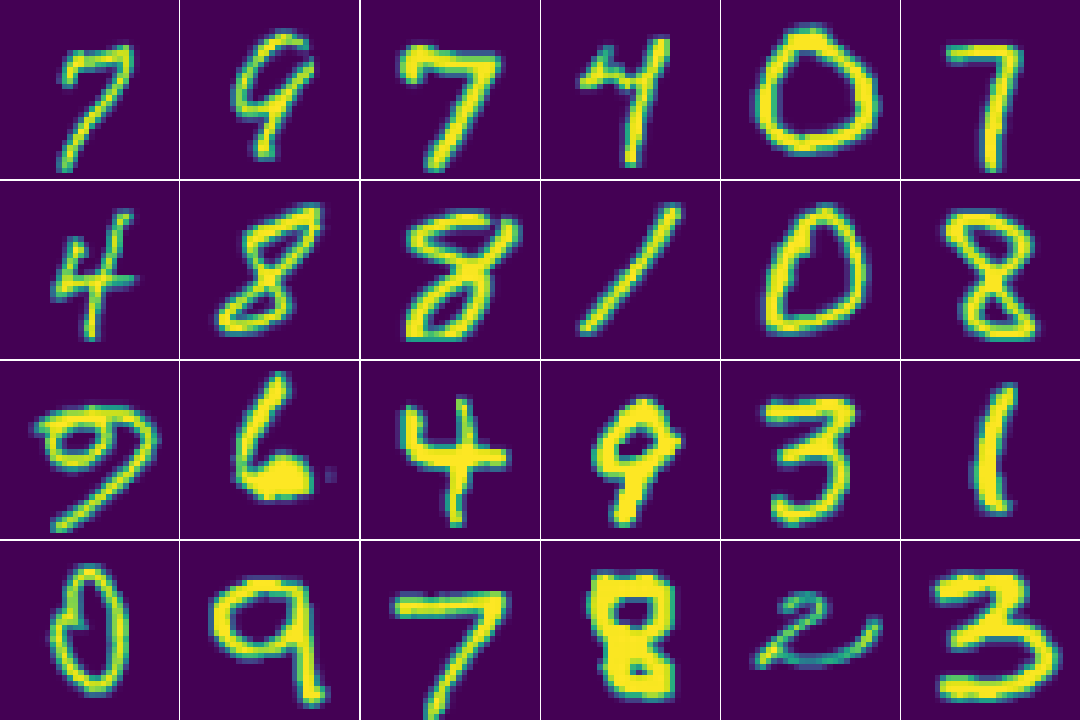

In [15]:
util.plot_imgs(X);

In [16]:
# with torch.no_grad():
#     logits = model(X)[0]
# util.plot_imgs(to_img(logits));

In [17]:
zs, ps = encode(X, t=0., prior=True)

<IPython.core.display.Javascript object>


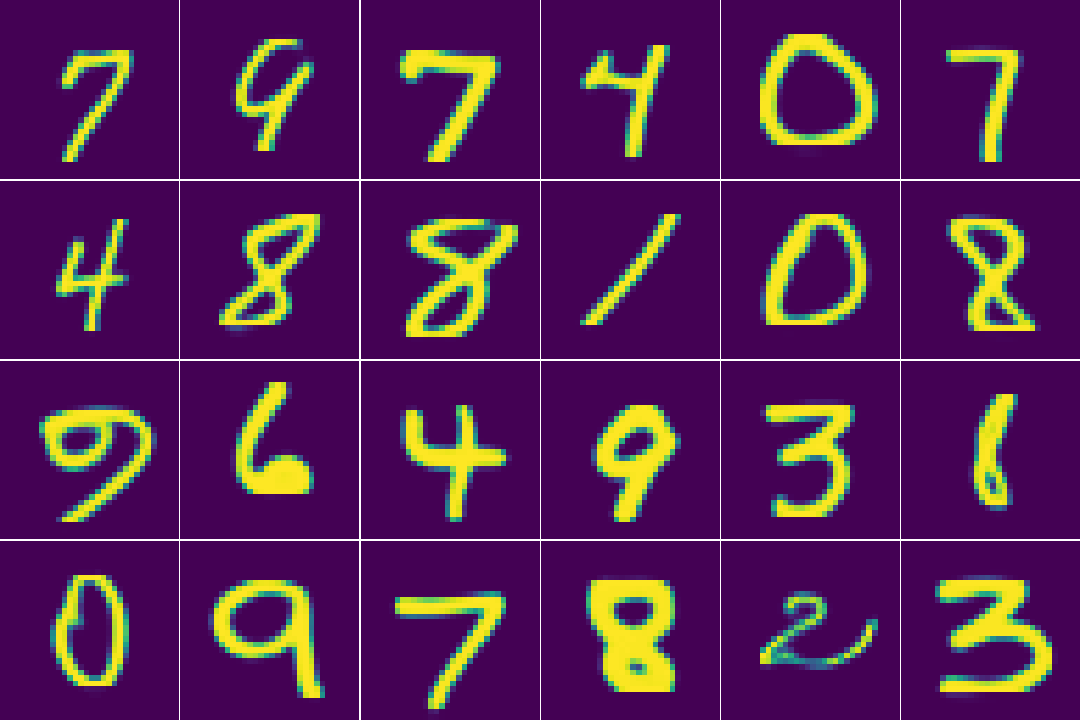

In [18]:
rec = decode(zs)
util.plot_imgs(to_img(rec));

<IPython.core.display.Javascript object>


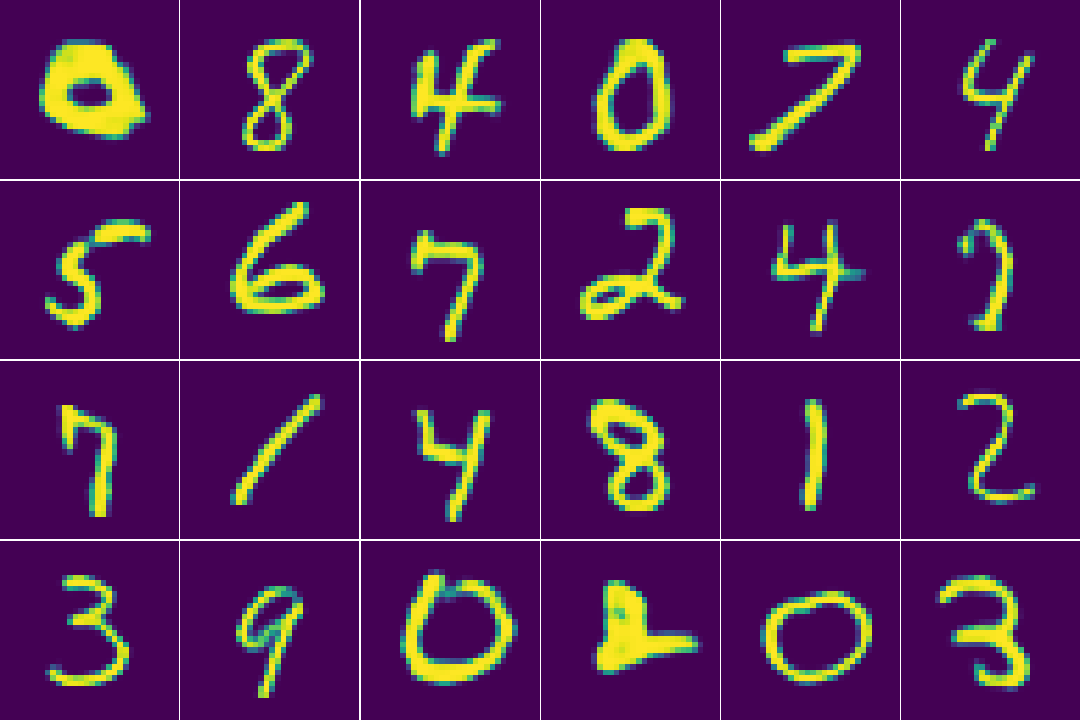

In [19]:
g = to_img(model.sample(24, t=1.))
util.plot_imgs(g);

In [22]:
# idx = np.random.randint(len(X))
x = X.clone()
# x = g.clone()
# x[:] = x[idx:idx+1]
Zs, Ps = encode(x, t=0., prior=True)

<IPython.core.display.Javascript object>


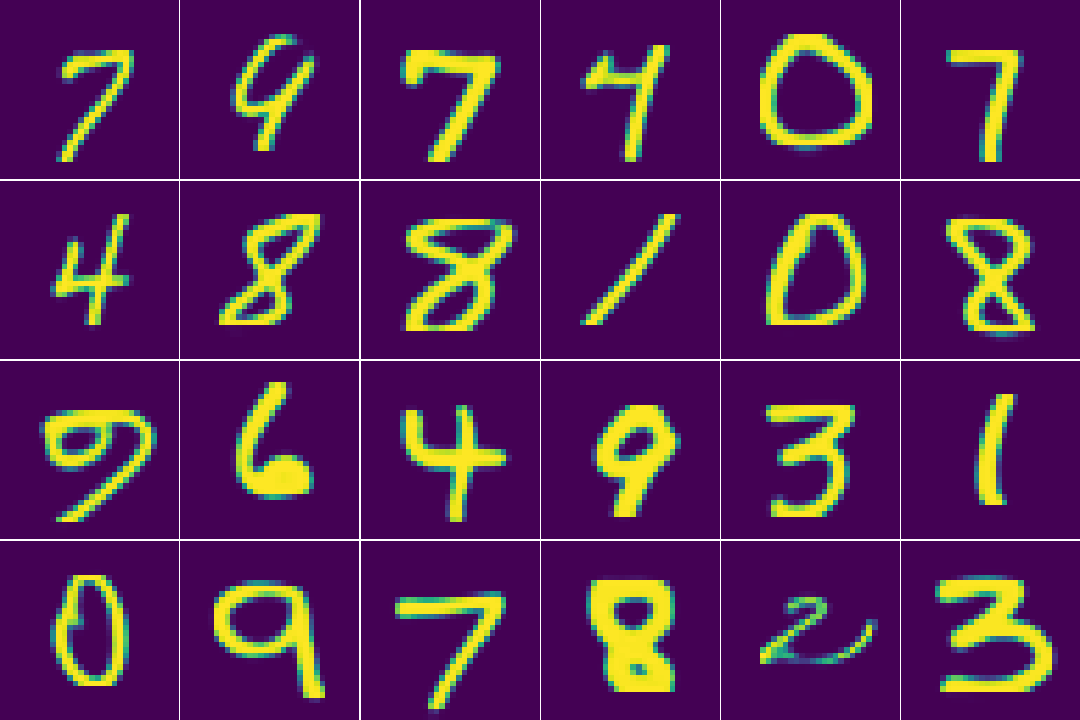

In [21]:
# util.plot_imgs(to_img(decode(encode(x,t=1))));
util.plot_imgs(to_img(decode(Zs)));

In [23]:
seqs = []
for num in range(1,len(Zs)):
    seqs.append(to_img(decode([*Zs[:num], Ps[num].sample()[0]],t=0.)))
seqs = torch.stack(seqs)
seqs.shape

torch.Size([14, 24, 1, 32, 32])

In [24]:
# bnum = 8
# sel = np.arange(len(x))[-5:]
# bnum = len(sel)
# util.plot_imgs(util.combine_dims(seqs[:, sel].contiguous(), start=0, end=2), W=bnum);

In [25]:
# num = 5
# zs = [*Zs[:num], Ps[num].sample()[0]]
# util.plot_imgs(to_img(decode(zs,t=0.)));

In [26]:
Ps[0].sample()[0].shape

torch.Size([24, 20, 4, 4])

In [27]:
# m = decode([Ps[0]], t=0)
# util.plot_imgs(to_img(decode([Ps[0]], t=0)));
# util.plot_imgs(to_img(decode([Ps[0]], t=0)));

In [28]:
# q = Zs[0].sigma
# q = Ps[0].sample()[0]
q = ps[0].sample()[0]
q.shape

torch.Size([24, 20, 4, 4])

In [29]:
# util.plot_imgs(to_img(decode([q], t=0)));

In [30]:
def enc(x):
    return encode(x, t=0)[0]
def dec(q):
    return to_img(decode([q], t=0))

In [31]:
rdist = enc(dec(q))
sigma = rdist.sigma.mean(0)
sigma.shape

torch.Size([20, 4, 4])

In [32]:
dims = []
informative = (sigma < 0.8)
for ind in np.ndindex(sigma.shape):
    if informative[ind]:
        dims.append(ind)
print(dims)

[(3, 2, 1), (3, 3, 1), (3, 3, 3)]


In [33]:
if dname == 'mnist':
    _dims = [(3, 2, 1), (3, 3, 1), (3, 3, 3)]
    _shape = [20,4,4]
elif dname == 'celeba_64':
    _shape = [20,8,8]
    _dims = [(13, 0, 0), (13, 0, 1), (13, 0, 2), (13, 0, 3), (13, 0, 4), (13, 0, 5), (13, 0, 6), (13, 0, 7), (13, 1, 0), (13, 1, 1), (13, 1, 2), (13, 1, 3), (13, 1, 4), (13, 1, 5), (13, 1, 6), (13, 1, 7), (13, 2, 0), (13, 2, 1), (13, 2, 2), (13, 2, 3), (13, 2, 4), (13, 2, 5), (13, 2, 6), (13, 2, 7), (13, 3, 0), (13, 3, 1), (13, 3, 2), (13, 3, 3), (13, 3, 4), (13, 3, 5), (13, 3, 6), (13, 3, 7), (13, 4, 0), (13, 4, 1), (13, 4, 2), (13, 4, 3), (13, 4, 4), (13, 4, 5), (13, 4, 6), (13, 4, 7), (13, 5, 0), (13, 5, 1), (13, 5, 2), (13, 5, 3), (13, 5, 4), (13, 5, 5), (13, 5, 6), (13, 5, 7), (13, 6, 0), (13, 6, 1), (13, 6, 2), (13, 6, 3), (13, 6, 4), (13, 6, 5), (13, 6, 6), (13, 6, 7), (13, 7, 0), (13, 7, 1), (13, 7, 2), (13, 7, 3), (13, 7, 4), (13, 7, 5), (13, 7, 6), (13, 7, 7)]
din = len(_dims)
_dims = list(zip(*_dims))
def E(x):
    return enc(x.cuda()).mu[(slice(None),*_dims)].cpu()
def D(q):
    z = torch.zeros(len(q), *_shape).to(q.device)
    z[(slice(None),*_dims)] = q
    return dec(z.cuda()).cpu()
def R(q):
    return E(D(q))
def prior(N):
    return torch.randn(N, len(_dims[0]))#.cuda()



In [34]:
lat = prior(12)
lat.shape

torch.Size([12, 3])

<IPython.core.display.Javascript object>


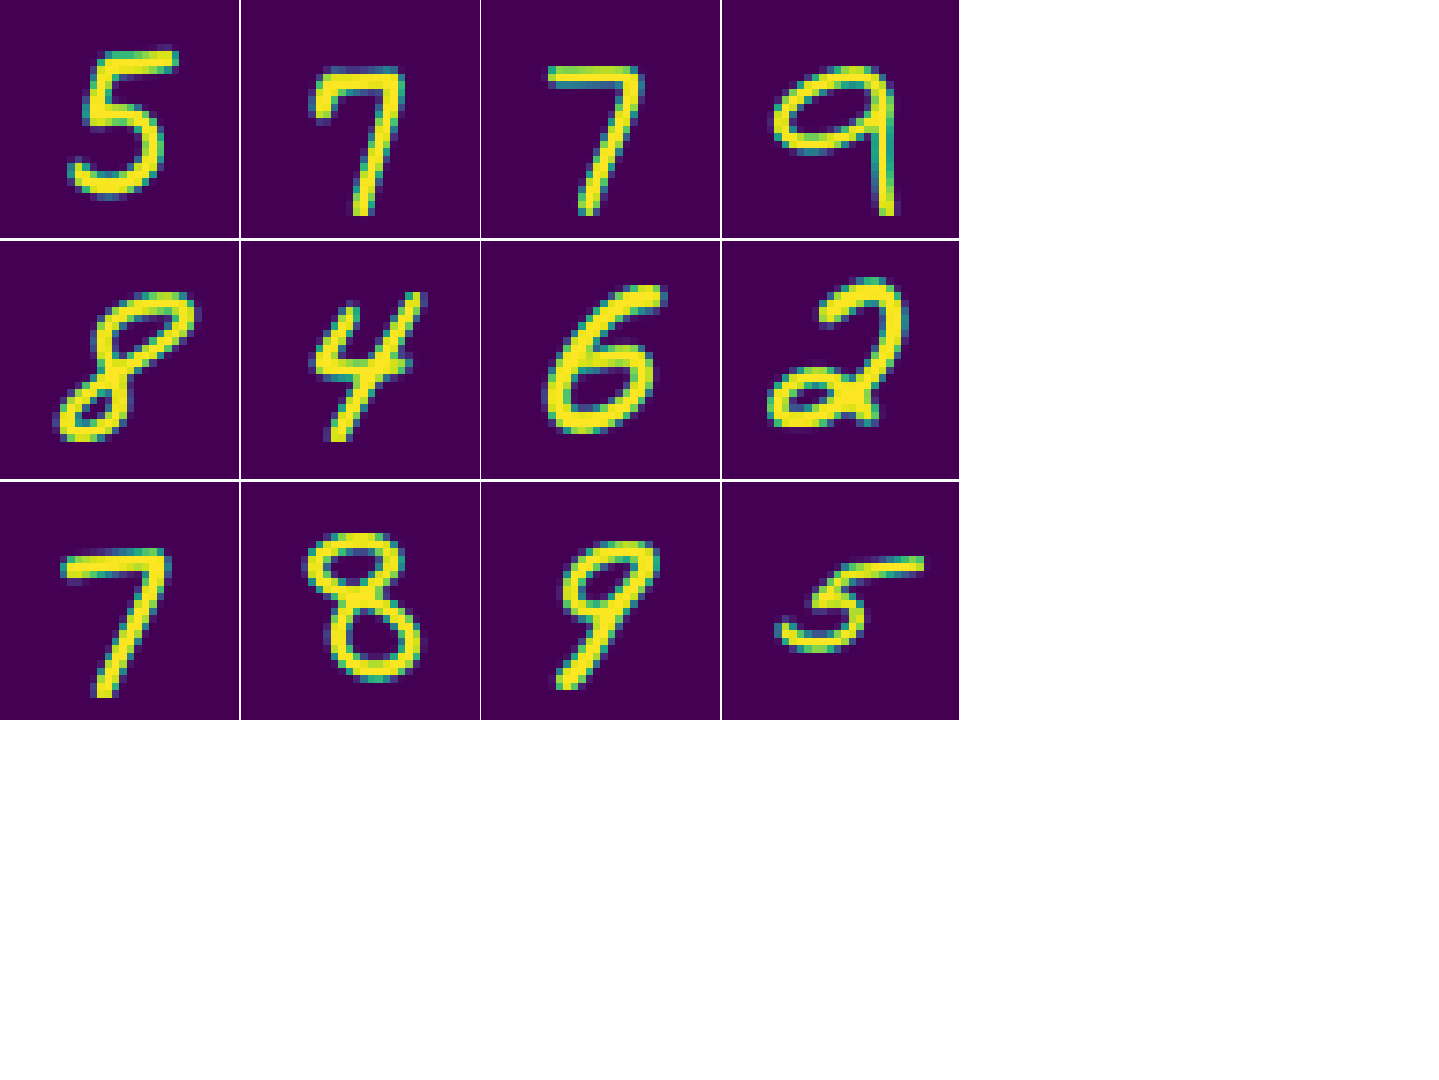

In [35]:
util.plot_imgs(D(lat));
# util.plot_imgs(D(E(D(lat))));

In [36]:
lat.shape

torch.Size([12, 3])

In [37]:
def interpolate(x,y,n=10):
    delta = torch.linspace(0,1,n).view(1,n,1).to(x.device)
    x = x.unsqueeze(1)
    y = y.unsqueeze(1)
    return delta*y + (1-delta)*x

In [38]:
sel = np.arange(len(lat))[:2]
nsteps = 10
trav = interpolate(lat[sel], lat[(sel+1)%len(lat)], nsteps)
trav.shape

torch.Size([2, 10, 3])

<IPython.core.display.Javascript object>


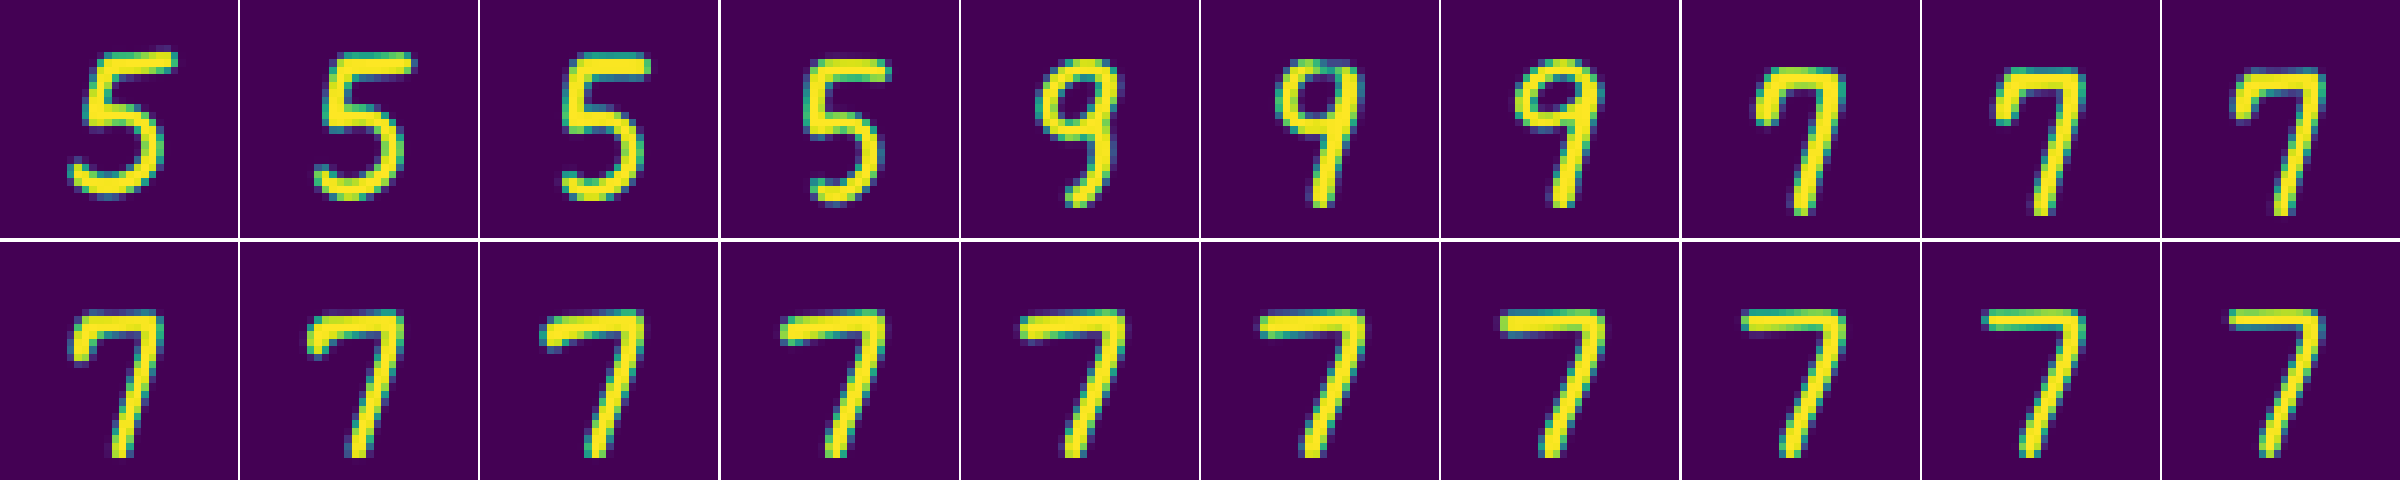

In [39]:
util.plot_imgs(D(util.combine_dims(trav,0,2).contiguous()), W=nsteps);

In [40]:
niter = 4
qs = [lat]
rs = []

In [41]:
for _ in tqdm(range(niter)):
    rs.append(D(qs[-1]))
    qs.append(E(rs[-1]))
rs = torch.stack(rs)
qs = torch.stack(qs)
qs.shape, rs.shape

<ipython-input-41-21356a626655>:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for _ in tqdm(range(niter)):


  0%|          | 0/4 [00:00<?, ?it/s]

(torch.Size([5, 12, 3]), torch.Size([4, 12, 1, 32, 32]))

<IPython.core.display.Javascript object>


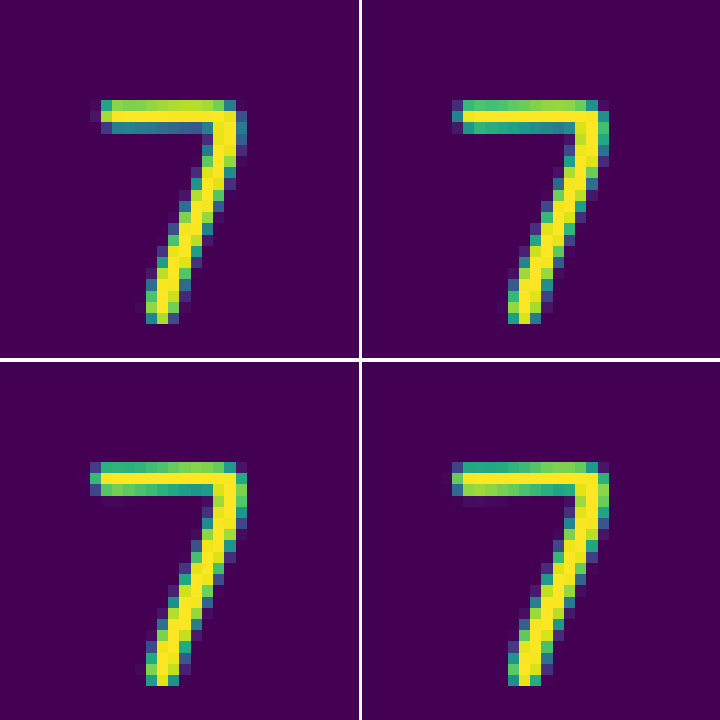

In [42]:
util.plot_imgs(rs[:,np.random.randint(rs.shape[1])]);

In [43]:
fullQ = []
total = 10000
bs = 100
loader = dataset.get_loader(infinite=True, shuffle=True, seed=0, batch_size=bs)
loader = iter(loader)
pbar = tqdm(total=total)
while len(fullQ) < total//bs:
    x = next(loader)[0]
    fullQ.append(E(x))
    pbar.update(bs)
del loader
fullQ = torch.cat(fullQ)
dout = fullQ.size(-1)
fullQ.shape

<ipython-input-43-f3d6926e24a1>:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  pbar = tqdm(total=total)


  0%|          | 0/10000 [00:00<?, ?it/s]

torch.Size([10000, 3])

In [44]:
Q = lat.clone()
Q.shape

torch.Size([12, 3])

In [45]:
dims = 0,1
# dims = 1,2

ix, iy = dims
dims

(0, 1)

In [46]:
Qsel = Q[:,dims]
pt = Qsel.sub(Qsel.mean(0,keepdim=True))
# plt.figure()
# plt.scatter(*pts.t(), marker='.', c='k');
U, S, V = torch.svd(pt.t() @ pt / (len(pt) - 1))
S = S.sqrt()
print('S',S)
print(U)
Q.shape, Qsel.shape

S tensor([1.3854, 1.0974])
tensor([[ 0.1882,  0.9821],
        [ 0.9821, -0.1882]])


(torch.Size([12, 3]), torch.Size([12, 2]))

In [47]:
stretch = .2
rg = 2.5

mn, mx = Q.min(0)[0].unsqueeze(-1)-stretch*rg, Q.max(0)[0].unsqueeze(-1)+stretch*rg
mn, mx = mn.view(-1), mx.view(-1)

print(mn[list(dims)], mx[list(dims)])

mn, mx = torch.ones(len(mn))*-rg, torch.ones(len(mx))*rg

tensor([-2.8793, -2.3381]) tensor([2.3120, 2.9237])


In [48]:
bidx = 9
bidx = 0
z0 = 0.
Q[bidx,-1] = z0
Q[bidx]

tensor([-0.2817, -0.3756,  0.0000])

In [49]:
n = 200
h, w = n, n

xvals, yvals = torch.linspace(mn[ix].item(),mx[ix].item(),h), torch.linspace(mn[iy].item(),mx[iy].item(),w)
# xvals, yvals = torch.linspace(-rg,rg,h), torch.linspace(-rg,rg,w)
cx, cy = torch.meshgrid(xvals, yvals)
cx = cx.reshape(-1)
cy = cy.reshape(-1)

vecs = Q[bidx:bidx+1].expand(len(cx), -1).contiguous()
vecs[:, ix] = cx
vecs[:, iy] = cy
vecs.shape

torch.Size([10000, 3])

In [50]:
starts = vecs[...,dims]
ends = []
for v, in tqdm(DataLoader(TensorDataset(vecs), batch_size=100), desc=f'Cycling {len(vecs)} samples'):
    with torch.no_grad():
        ends.append(R(v)[...,dims])
starts = starts.view(h,w,2)
ends = torch.cat(ends).view(h,w,2)
dels = ends.sub(starts)
delmap = dels.permute(1,0,2).numpy()[::-1]
ends.shape

<ipython-input-50-dea9ee02cac7>:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for v, in tqdm(DataLoader(TensorDataset(vecs), batch_size=100), desc=f'Cycling {len(vecs)} samples'):


Cycling 10000 samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([100, 100, 2])

In [51]:
# # dmap = torch.cdist(starts, Qsel).min(-1)[0].view(n,n)
# dmap = torch.cdist(starts, cts).min(-1)[0].view(n,n)
# # dmap = torch.cdist(starts, Qsel).mean(-1).view(n,n)
# distmap = dmap.numpy()
# dmap = dmap.t().numpy()[::-1]

mags = dels.pow(2).sum(-1)
costmap = mags.numpy()
mags = mags.t().numpy()[::-1]
# mags = deltas.view(h,w,2)[...,0]

normdels = dels.div(dels.norm(dim=-1,keepdim=True))
def get_divergence(deltas):
    divx, divy = np.gradient(deltas, axis=[0,1])
    divM = divx[...,0] + divy[...,1]
    return torch.from_numpy(divM)
divM = get_divergence(dels)
ndivM = get_divergence(normdels)

happymap = divM<0
happy = happymap.t().numpy()[::-1]
# landscape = divM - divM.min()
# divM -= divM.min()
divergence = divM
divM = divM.t().numpy()[::-1]
posterior_logits = ndivM.mul(-1)
ndivM = posterior_logits.t().numpy()[::-1]

divMprop = torch.from_numpy(divM.copy()).clone()
divMprop[divMprop>0] /= divMprop[divMprop>0].max().abs()
divMprop[divMprop<0] /= divMprop[divMprop<0].min().abs()
divMprop = divMprop.numpy()

ndivMprop = torch.from_numpy(ndivM.copy()).clone()
ndivMprop[divMprop>0] /= ndivMprop[divMprop>0].max().abs()
ndivMprop[divMprop<0] /= ndivMprop[divMprop<0].min().abs()
ndivMprop = ndivMprop.numpy()


# fmag = mags + dmap
# spacemap = distmap + costmap

fmag = mags
spacemap = costmap

In [52]:
def cdf(x):
    return x.div(np.sqrt(2)).erf().add(1).div(2)
dx = xvals[1]-xvals[0]
xedges = torch.linspace(xvals[0]-dx/2,xvals[-1]+dx/2,w+1)
dy = yvals[1]-yvals[0]
yedges = torch.linspace(yvals[0]-dy/2,yvals[-1]+dy/2,h+1)
xcdf = cdf(xedges)
xprob = xcdf[1:] - xcdf[:-1]
ycdf = cdf(yedges)
yprob = ycdf[1:] - ycdf[:-1]
xyprob = torch.stack(torch.meshgrid(xprob, yprob)).prod(0)
xyprob.sum(), xyprob[~happymap].sum(), xyprob[~happymap].sum().div(xyprob.sum())

(tensor(0.9770), tensor(0.2875), tensor(0.2943))

<IPython.core.display.Javascript object>


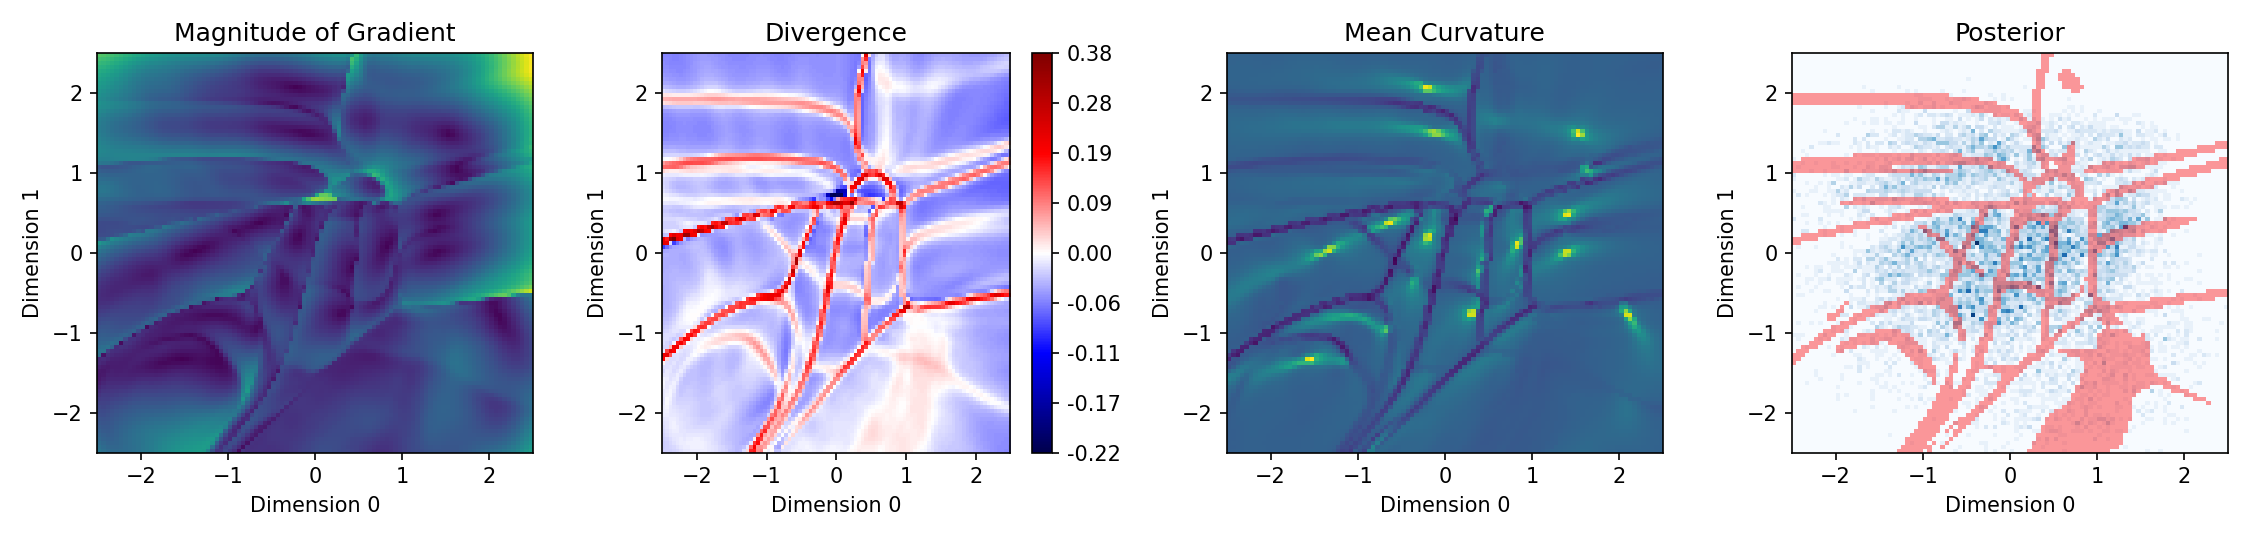

In [53]:
im = fmag
im = divM
# im = happy

# plt.figure()
# # plt.title('Map')
# plt.xlabel(f'Dimension {ix}')
# plt.ylabel(f'Dimension {iy}')
# plt.imshow(im, extent=[xvals.min(),xvals.max(),yvals.min(),yvals.max()]);
# plt.tight_layout()

aspect_ratio = 'auto'
# aspect_ratio = 1

fg, axs = plt.subplots(1,4, figsize=(15,3.6))

plt.sca(axs[0])
plt.title('Magnitude of Gradient')
plt.xlabel(f'Dimension {ix}')
plt.ylabel(f'Dimension {iy}')
plt.imshow(mags**0.5, extent=[xvals.min(),xvals.max(),yvals.min(),yvals.max()], aspect=aspect_ratio);
# plt.imshow(ndivM);


plt.sca(axs[1])
# plt.title('Distance Mags')
# plt.imshow(dmap, extent=[xvals.min(),xvals.max(),yvals.min(),yvals.max()]);
plt.title('Divergence')
plt.imshow(divMprop, cmap='seismic', extent=[xvals.min(),xvals.max(),yvals.min(),yvals.max()], aspect=aspect_ratio);
cbar = plt.colorbar()
axvals = np.concatenate([np.linspace(divM.min(), 0,5), np.linspace(0,divM.max(),5)[1:]])
axlbls = [f'{v.item():.2f}' for v in axvals]
cbar.set_ticks(np.linspace(-1, 1,9))
cbar.set_ticklabels(axlbls)
# cbar.set_ticks(np.linspace(-1, 1,9), np.linspace(divM.min(), divM.max(),9))
# plt.imshow(divM);
plt.xlabel(f'Dimension {ix}')
plt.ylabel(f'Dimension {iy}')

plt.sca(axs[2])
plt.title('Mean Curvature')
plt.xlabel(f'Dimension {ix}')
plt.ylabel(f'Dimension {iy}')
plt.imshow(ndivMprop, extent=[xvals.min(),xvals.max(),yvals.min(),yvals.max()], aspect=aspect_ratio);
# plt.imshow(ndivM);


plt.sca(axs[3])
plt.title('Posterior')
plt.xlabel(f'Dimension {ix}')
plt.ylabel(f'Dimension {iy}')
plt.xlim(xvals.min(),xvals.max(),)
plt.ylim(yvals.min(),yvals.max())
hist, *other = np.histogram2d(*fullQ[...,dims].t().cpu().numpy(), bins=n, normed=True, range=torch.stack([mn[list(dims)], mx[list(dims)]]).t().cpu().numpy())
plt.imshow(hist.T[::-1], cmap='Blues',
           extent=[xvals.min(),xvals.max(),yvals.min(),yvals.max()], aspect=aspect_ratio)
# plt.imshow(mags, extent=[xvals.min(),xvals.max(),yvals.min(),yvals.max()], aspect=aspect_ratio);
badsel = np.ones((*happy.shape,4))
badsel[...,-1] = 0.
badsel[~happy] = [1,0,0,1]
plt.imshow(badsel, #np.stack([happy, np.ones_like(happy), np.ones_like(happy), ], -1)*255,
#            cmap='Reds', alpha=0.8,
           alpha=0.4,
           extent=[xvals.min(),xvals.max(),yvals.min(),yvals.max()], aspect=aspect_ratio)
# plt.imshow(mags);
plt.tight_layout()


In [54]:
def even_samples(N, *shape):
    samples = []
    total = 0.
    for _ in range(N):
        samples.append(torch.randn(*shape) - total)
        total += samples[-1]
    return torch.stack(samples)
def normalize(x):
    N, *shape = x.shape
    mag = x.view(N,-1).norm(2,-1).view(N, *([1]*(len(x.shape)-1)))
    return x.div(mag)

<IPython.core.display.Javascript object>


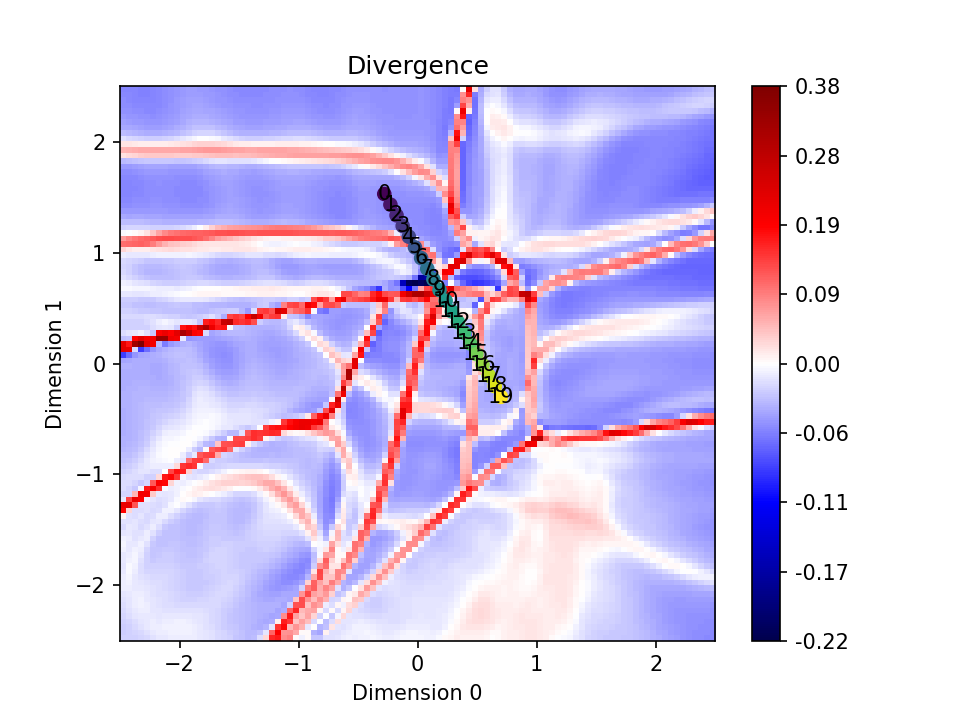

<IPython.core.display.Javascript object>


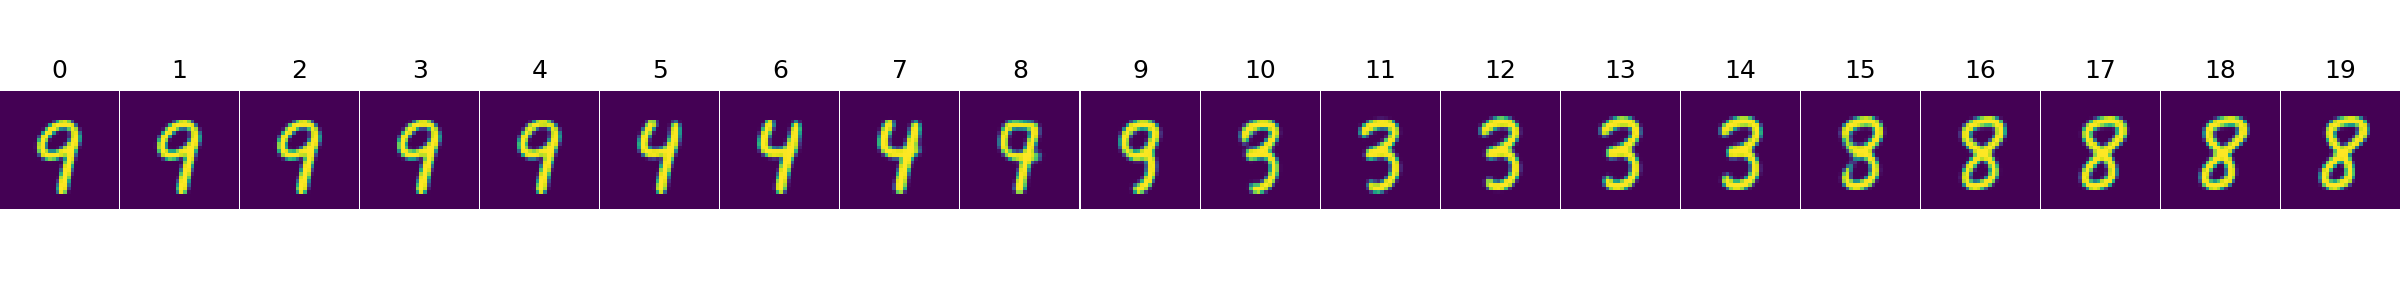

  0%|          | 0/2 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


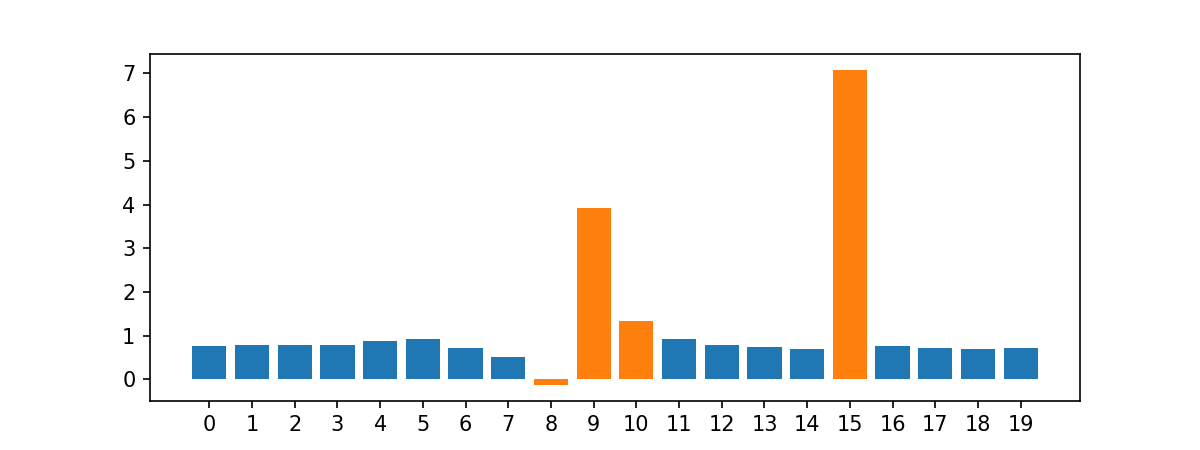

In [70]:
nsteps = 20
qp = torch.randn(2,din)
qp[0,:2] = torch.as_tensor([-0.28, 1.53])
qp[1,:2] = torch.as_tensor([0.7, -0.3])
qp[:,-1] = z0
qinp = interpolate(qp[[0]], qp[[1]], nsteps)[0]
qinp.shape, qp

plt.figure()
ax = plt.gca()
plt.title('Divergence')
plt.imshow(divMprop, cmap='seismic', extent=[xvals.min(),xvals.max(),yvals.min(),yvals.max()], aspect=aspect_ratio);
cbar = plt.colorbar()
axvals = np.concatenate([np.linspace(divM.min(), 0,5), np.linspace(0,divM.max(),5)[1:]])
axlbls = [f'{v.item():.2f}' for v in axvals]
cbar.set_ticks(np.linspace(-1, 1,9))
cbar.set_ticklabels(axlbls)
# cbar.set_ticks(np.linspace(-1, 1,9), np.linspace(divM.min(), divM.max(),9))
# plt.imshow(divM);
plt.xlabel(f'Dimension {ix}')
plt.ylabel(f'Dimension {iy}');

qi = qinp[:,dims]
plt.scatter(*qi.t(), c=torch.linspace(0,1,len(qi)))

xinp = D(qinp)
fg, axs = util.plot_imgs(xinp, W=nsteps)

plt.sca(ax)
for i, (x,y) in enumerate(qi):
    plt.text(x.item(),y.item(), s=str(i), ha='center', va='center')
for i, ax in enumerate(axs):
    plt.sca(ax)
    plt.title(str(i))

dm = din

b = 10
scale = 0.001

# eps = torch.randn(b+1, dm)
eps = even_samples(b+1, dm)
eps = normalize(eps)
eps *=  scale
eps[0] *= 0

# base = qp.clone()
base = qinp.clone()
samples = base.unsqueeze(0) + eps.unsqueeze(1)
resp = util.process_in_batches(R, samples.view(-1, dm), batch_size=128, pbar=tqdm).view(*samples.shape)
rp = resp[1:] - resp[:1]
deltas = eps[1:].unsqueeze(1) / scale**2
out = rp @ deltas.permute(0,2,1)
# out = rp.sum(-1) / scale
dv = out.mean(0).squeeze(-1) 
# dv = out.max(0)[0].squeeze(-1) 

plt.figure(figsize=(8,3))
plt.bar(np.arange(len(dv)),dv, color=[f'C{int(0>v or v>1)}' for v in dv])
plt.xticks(np.arange(len(dv)), map(str, np.arange(len(dv))));

In [59]:
# shape = 10,10
# N = 50
# r = torch.randn(N,*shape)
# x = even_samples(N, *shape)
# r = normalize(r)
# x = normalize(x)
# # fg, (ax1, ax2) = plt.subplots(2)
# # plt.sca(ax1)
# # plt.scatter(*x.t())
# # plt.sca(ax2)
# # plt.scatter(*r.t())
# print(x.mean(0).view(-1).norm(2), r.mean(0).view(-1).norm(2))

# Full Latent Space

<IPython.core.display.Javascript object>


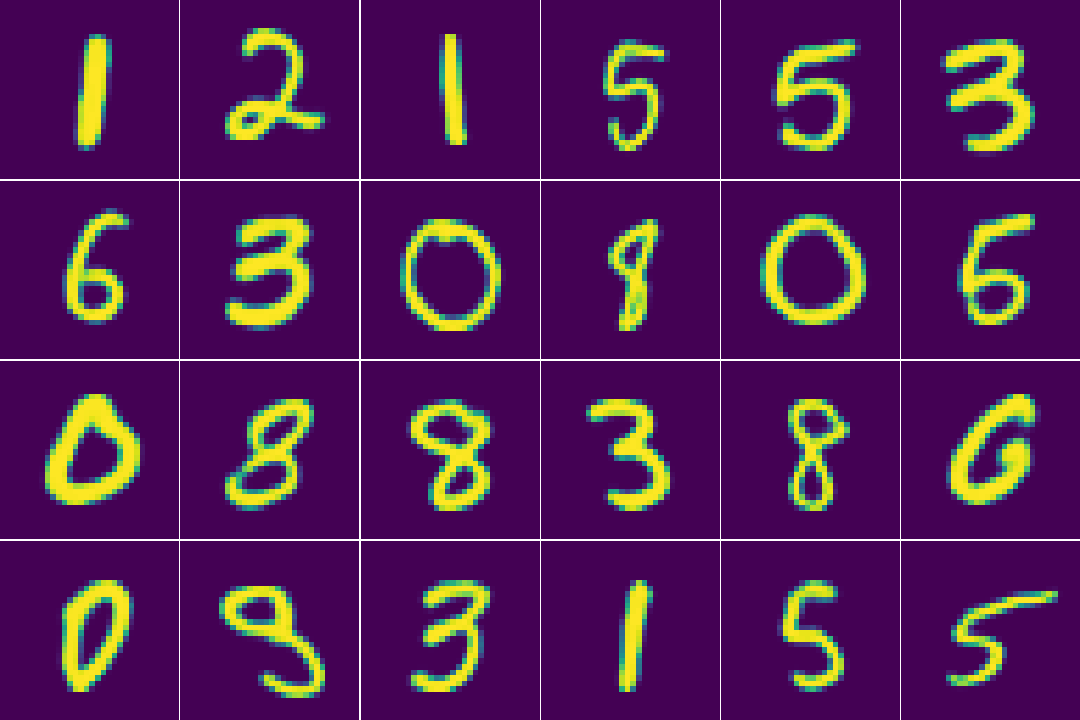

In [312]:
inits = to_img(model.sample(24, t=0.6))
util.plot_imgs(inits);

c:\users\anwan\onedrive\khan\research\foundation\omnilearn\util\viz.py:349: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fg, axes = plt.subplots(H, W, figsize=figsize)


<IPython.core.display.Javascript object>


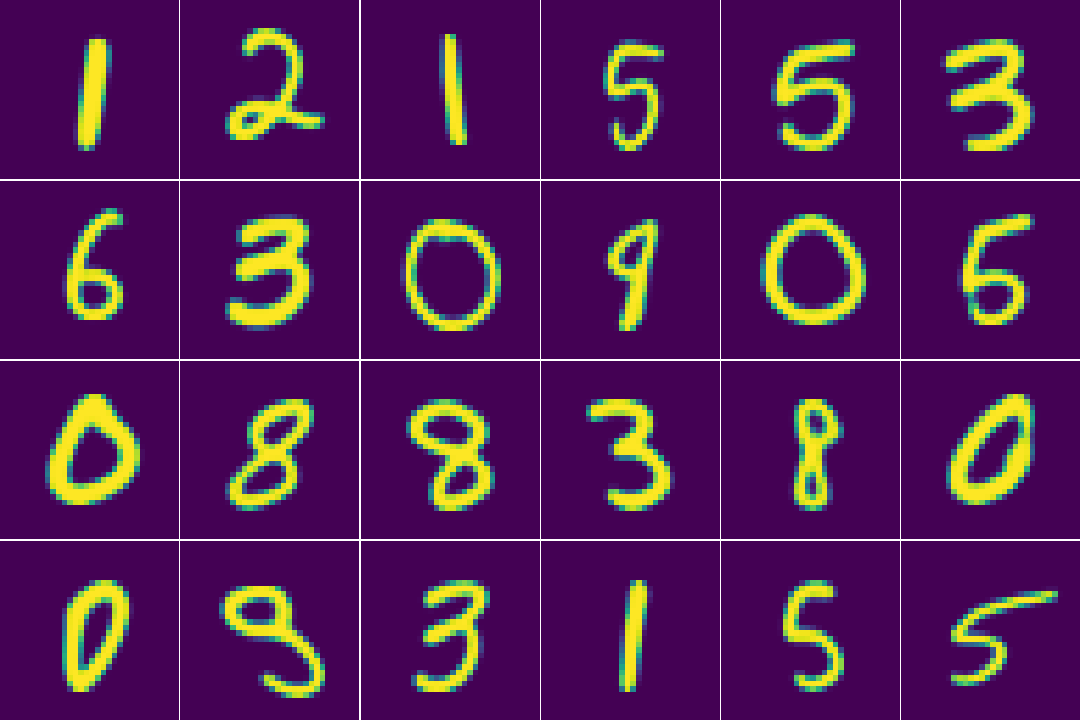

In [374]:
lats = encode(inits, t=0.1)
rec = to_img(decode(lats))
util.plot_imgs(rec);

In [375]:
from torch.utils.data import DataLoader, TensorDataset

In [378]:
bnum = 10

samples = [torch.cat([lat.sample()[0] for _ in range(bnum)]) for lat in lats]
base = [lat.mu for lat in lats]
len(samples), len(base)

bs = 64
niter = len(DataLoader(TensorDataset(samples[0]), batch_size=bs))
feed = [iter(DataLoader(TensorDataset(z), batch_size=bs)) for z in samples]
Rs = []
for z in tqdm(zip(*feed), total=niter):
#     break
    Rs.append([rdist.mu for rdist in encode(to_img(decode([_z[0] for _z in z])),t=0)])
Rs = [torch.cat(rzs) for rzs in zip(*Rs)]
Rb = [b.mu for b in encode(to_img(decode(base)),t=0)]

dvs = []

for s, b, rs, rb in zip(samples, base, Rs, Rb):
    N = b.shape[0]
    s = s.view(bnum, N, -1)
    rs = rs.view(bnum, N, -1)
    b = b.view(1, N, -1)
    rb = rb.view(1, N, -1)
    
    
    eps = s - b
    scale = eps.norm(2,-1,True)
    
    rp = rs - rb
    rp = rp / scale
    deltas = eps / scale
    out = rp.mul(deltas).sum(-1)
    # out = rp.sum(-1) / scale
    dv = out.mean(0).squeeze(-1).cpu()
    
    dvs.append(dv)

# len(Rs), len(Rb)

<ipython-input-378-411001c97774>:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for z in tqdm(zip(*feed), total=niter):


  0%|          | 0/4 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


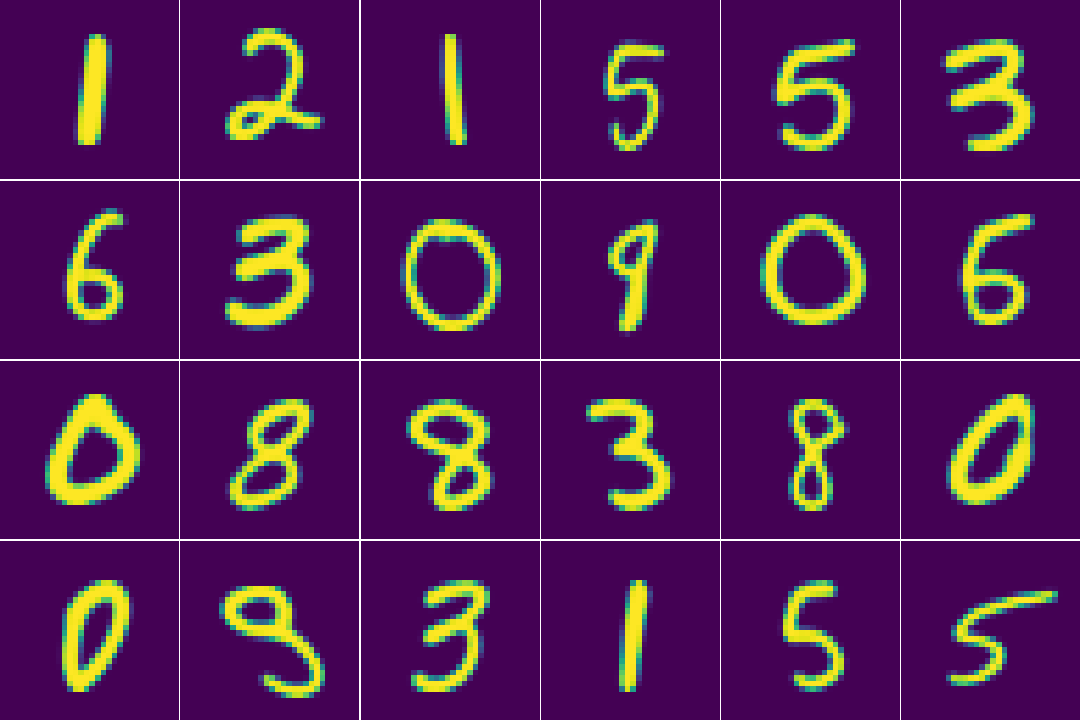

<IPython.core.display.Javascript object>


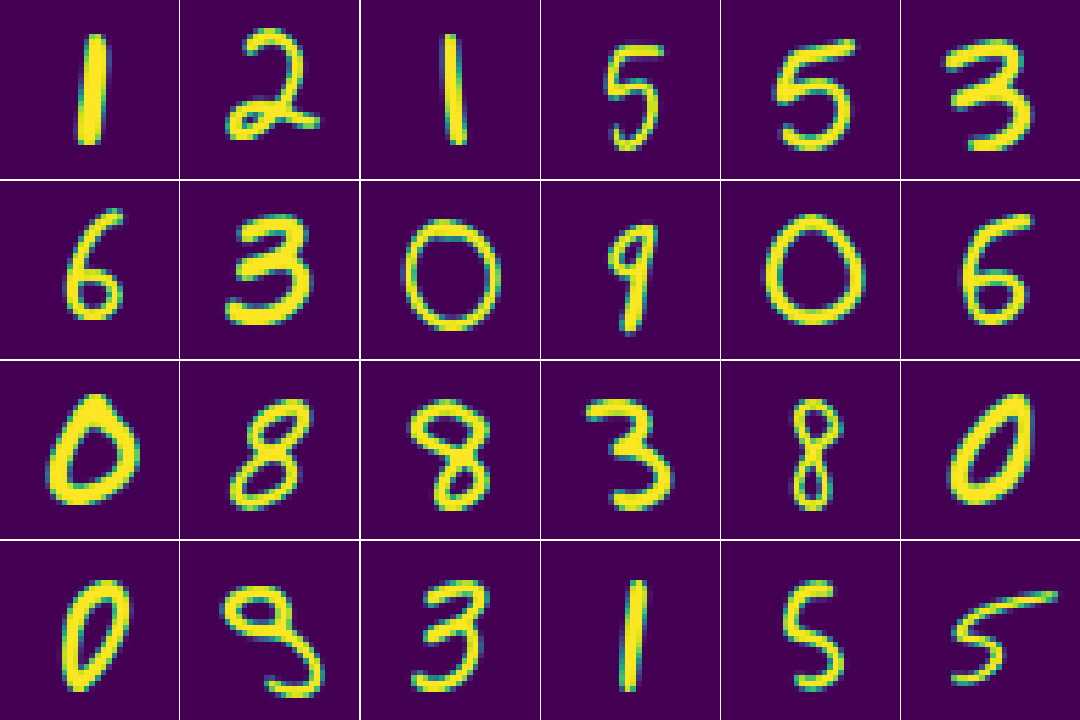

<ipython-input-379-5f59d65630cb>:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(8,3))


<IPython.core.display.Javascript object>


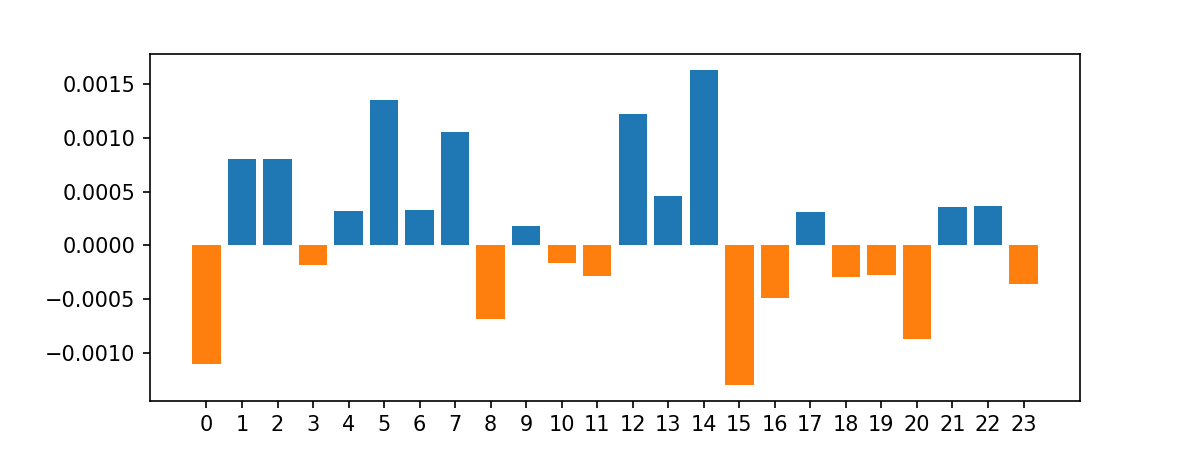

In [379]:
# util.plot_imgs(to_img(decode(Rs)));
util.plot_imgs(to_img(decode(base)));
util.plot_imgs(to_img(decode(Rb)));

dv = sum(dvs) / len(dvs)

plt.figure(figsize=(8,3))
plt.bar(np.arange(len(dv)),dv, color=[f'C{int(0>v or v>1)}' for v in dv])
plt.xticks(np.arange(len(dv)), map(str, np.arange(len(dv))));